In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
import requests
from io import BytesIO
from tensorflow.keras.preprocessing import image

# --- CONFIGURATION ---
# This assumes the 'flowers' folder is right next to your code
DATA_DIR = os.path.join(os.getcwd(), 'flowers') 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Verify Python can find the folder
if not os.path.exists(DATA_DIR):
    print(f"ERROR: Cannot find data at {DATA_DIR}")
    print("Please make sure you unzipped the 'flowers' folder into the same directory as this code.")
else:
    print(f"SUCCESS: Data found at {DATA_DIR}")
    print("Classes found:", os.listdir(DATA_DIR))

SUCCESS: Data found at c:\Aakash's File\ML task\Flower-Recognition\flowers
Classes found: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [9]:
# Create Data Generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [12]:
print("--- Training Custom CNN ---")
model_custom = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_custom = model_custom.fit(train_generator, validation_data=val_generator, epochs=5)

# Save the model so you don't have to retrain next time
model_custom.save('my_custom_model.h5')
print("Custom Model Saved!")

--- Training Custom CNN ---
Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.4779 - loss: 1.3770 - val_accuracy: 0.5849 - val_loss: 1.0763
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.6109 - loss: 0.9751 - val_accuracy: 0.6442 - val_loss: 0.9451
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.6778 - loss: 0.8518 - val_accuracy: 0.6535 - val_loss: 0.8948
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.6827 - loss: 0.8240 - val_accuracy: 0.6907 - val_loss: 0.8368
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 404s 4s/step - accuracy: 0.7318 - loss: 0.7176 - val_accuracy: 0.6884 - val_loss: 0.8387


Custom Model Saved!


In [13]:
# --- Step 3: Build & Train Transfer Learning Model (Task B) ---
print("\nStarting Task B: Transfer Learning (MobileNetV2)...")

# Download the pre-trained brain
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False # Freeze it so we don't break what it already knows

model_transfer = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_transfer = model_transfer.fit(train_generator, validation_data=val_generator, epochs=10)
print("Task B Complete!")


Starting Task B: Transfer Learning (MobileNetV2)...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 489s 4s/step - accuracy: 0.7776 - loss: 0.5870 - val_accuracy: 0.8558 - val_loss: 0.3873
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 362s 3s/step - accuracy: 0.8808 - loss: 0.3456 - val_accuracy: 0.8558 - val_loss: 0.3885
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.9074 - loss: 0.2641 - val_accuracy: 0.8500 - val_loss: 0.4074
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 447s 4s/step - accuracy: 0.9259 - loss: 0.2122 - val_accuracy: 0.8907 - val_loss: 0.3285
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 532s 4s/step - accuracy: 0.9398 - loss: 0.1832 - val_accuracy: 0.8686 - val_loss: 0.3974
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 421s 4s/step - accuracy: 0.9485 - loss: 0.1524 - val_accuracy: 0.8686 - val_loss: 0.3785
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.9569 - loss: 0.1291 - val_accuracy: 0.8651 - val_loss: 0.

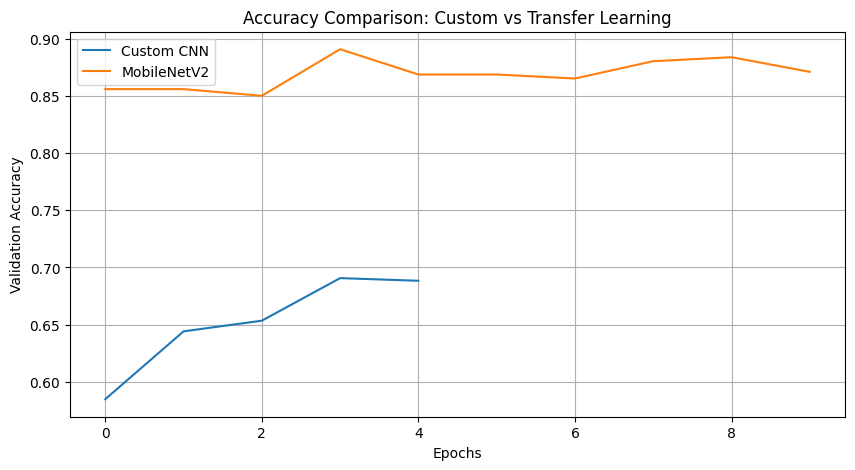

In [14]:
# --- Step 4: Comparison Graph ---
plt.figure(figsize=(10, 5))
plt.plot(history_custom.history['val_accuracy'], label='Custom CNN')
plt.plot(history_transfer.history['val_accuracy'], label='MobileNetV2')
plt.title('Accuracy Comparison: Custom vs Transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Models are ready!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


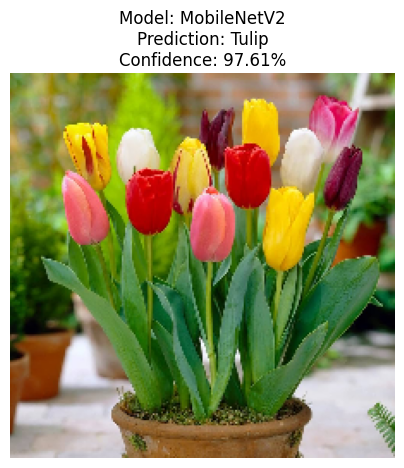

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


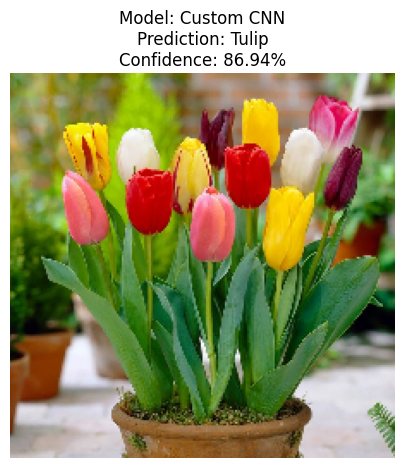

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import requests
from io import BytesIO

# --- STEP 1: LOAD MODELS (Only if starting fresh) ---
# If you just finished training in this session, you can skip this block.
try:
    if 'model_custom' not in globals():
        print("Loading Custom Model from disk...")
        model_custom = load_model('my_custom_model.h5')
        
    if 'model_transfer' not in globals():
        print("Loading Transfer Model from disk...")
        model_transfer = load_model('my_transfer_model.h5')
    print("Models are ready!")
except OSError:
    print("⚠️ Could not find saved model files.")
    print("If you haven't trained yet, please run the training code first.")

# --- STEP 2: DEFINE THE PREDICTION FUNCTION ---
def predict_flower_local(url, model, model_name):
    # We use a specific header to prevent websites from blocking Python
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    
    try:
        # 1. Download Image
        print(f"Downloading image from {url}...")
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # 2. Process Image
        img = image.load_img(BytesIO(response.content), target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize to 0-1
        img_array = np.expand_dims(img_array, axis=0) # Make batch of 1

        # 3. Predict
        predictions = model.predict(img_array)
        
        # Define classes (Must be alphabetical order to match flow_from_directory)
        class_names = ['Daisy', 'Dandelion', 'Rose', 'Sunflower', 'Tulip']
        
        predicted_index = np.argmax(predictions)
        predicted_class = class_names[predicted_index]
        confidence = 100 * np.max(predictions)
        
        # 4. Show Result
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Model: {model_name}\nPrediction: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.show()
        
    except requests.exceptions.RequestException as e:
        print(f"❌ Error downloading image: {e}")
    except Exception as e:
        print(f"❌ An error occurred: {e}")

# --- STEP 3: RUN THE TEST ---

# Image 1: A Sunflower
url_1 = "https://sakataornamentals.com/wp-content/uploads/sites/13/2022/02/Sunflower_Sunbright-A5-CROP-square.jpg"

# Image 2: A Rose (Uncomment to test)
url_2 = "https://m.media-amazon.com/images/I/71soQIzEeRL._AC_UF1000,1000_QL80_.jpg"

# Test with Transfer Learning Model (Smartest)
if 'model_transfer' in globals():
    predict_flower_local(url_1, model_transfer, "MobileNetV2")

# Test with Custom Model (To compare)
if 'model_custom' in globals():
    predict_flower_local(url_1, model_custom, "Custom CNN")

# Test with Transfer Learning Model (Smartest)
if 'model_transfer' in globals():
    predict_flower_local(url_2, model_transfer, "MobileNetV2")

# Test with Custom Model (To compare)
if 'model_custom' in globals():
    predict_flower_local(url_2, model_custom, "Custom CNN")